In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


In [1]:
import torch
import torch.nn as nn
from torch.nn import GRU
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

In [2]:
df=pd.read_csv('/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip',compression="zip")

In [3]:
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_31/3970806690.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [4]:
df.isnull().sum()

Page          0
2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
             ..
2016-12-27    0
2016-12-28    0
2016-12-29    0
2016-12-30    0
2016-12-31    0
Length: 551, dtype: int64

In [5]:
train=df.drop("Page",axis=1)


In [6]:
train.head(),train.shape


(   2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
 0        18.0        11.0         5.0        13.0        14.0         9.0   
 1        11.0        14.0        15.0        18.0        11.0        13.0   
 2         1.0         0.0         1.0         1.0         0.0         4.0   
 3        35.0        13.0        10.0        94.0         4.0        26.0   
 4        35.0        13.0        10.0        94.0         4.0        26.0   
 
    2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-22  \
 0         9.0        22.0        26.0        24.0  ...        32.0   
 1        22.0        11.0        10.0         4.0  ...        17.0   
 2         0.0         3.0         4.0         4.0  ...         3.0   
 3        14.0         9.0        11.0        16.0  ...        32.0   
 4        14.0         9.0        11.0        16.0  ...        48.0   
 
    2016-12-23  2016-12-24  2016-12-25  2016-12-26  2016-12-27  2016-12-28  \
 0        63.0        15

In [7]:
rows=train.iloc[56000,:].values


In [8]:
print(rows[:10]),len(rows)

[ 960. 1286. 1193. 1440. 1444. 1038. 1143. 1109. 1209. 1229.]


(None, 550)

In [9]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [10]:
X=rows[0:549]
y=rows[1:550]

In [11]:
#Lets split the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [12]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train.reshape(-1,1))
y_train=scaler.fit_transform(y_train.reshape(-1,1))
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [31]:
class gru_model(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(gru_model,self).__init__()
        self.GRU=nn.GRU(input_shape,hidden_shape,num_layers=2,batch_first=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_shape, 64),   # 2 * hidden_shape because the LSTM is bidirectional
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self,x):
        gru_out,_=self.GRU(x)
        out=self.fc(gru_out[:, -1, :])
        return out

In [32]:
model = gru_model(1,32, 1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
epochs = 500
gru_train_loss=[]
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    gru_train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')


Epoch [10/500], Loss: 0.007608
Epoch [20/500], Loss: 0.007531
Epoch [30/500], Loss: 0.006653
Epoch [40/500], Loss: 0.006715
Epoch [50/500], Loss: 0.006715
Epoch [60/500], Loss: 0.006324
Epoch [70/500], Loss: 0.006199
Epoch [80/500], Loss: 0.006242
Epoch [90/500], Loss: 0.005749
Epoch [100/500], Loss: 0.005218
Epoch [110/500], Loss: 0.004521
Epoch [120/500], Loss: 0.003020
Epoch [130/500], Loss: 0.002062
Epoch [140/500], Loss: 0.002273
Epoch [150/500], Loss: 0.002226
Epoch [160/500], Loss: 0.001586
Epoch [170/500], Loss: 0.001611
Epoch [180/500], Loss: 0.001637
Epoch [190/500], Loss: 0.001342
Epoch [200/500], Loss: 0.001826
Epoch [210/500], Loss: 0.001874
Epoch [220/500], Loss: 0.001796
Epoch [230/500], Loss: 0.001445
Epoch [240/500], Loss: 0.001337
Epoch [250/500], Loss: 0.001825
Epoch [260/500], Loss: 0.001224
Epoch [270/500], Loss: 0.001677
Epoch [280/500], Loss: 0.001523
Epoch [290/500], Loss: 0.001262
Epoch [300/500], Loss: 0.001422
Epoch [310/500], Loss: 0.001795
Epoch [320/500], 

In [34]:
X_test=scaler.fit_transform(X_test.reshape(-1,1))
y_test=scaler.fit_transform(y_test.reshape(-1,1))
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [35]:
X_test=X_test.to(device)
y_test=y_test.to(device)
y_train=y_train.to(device)

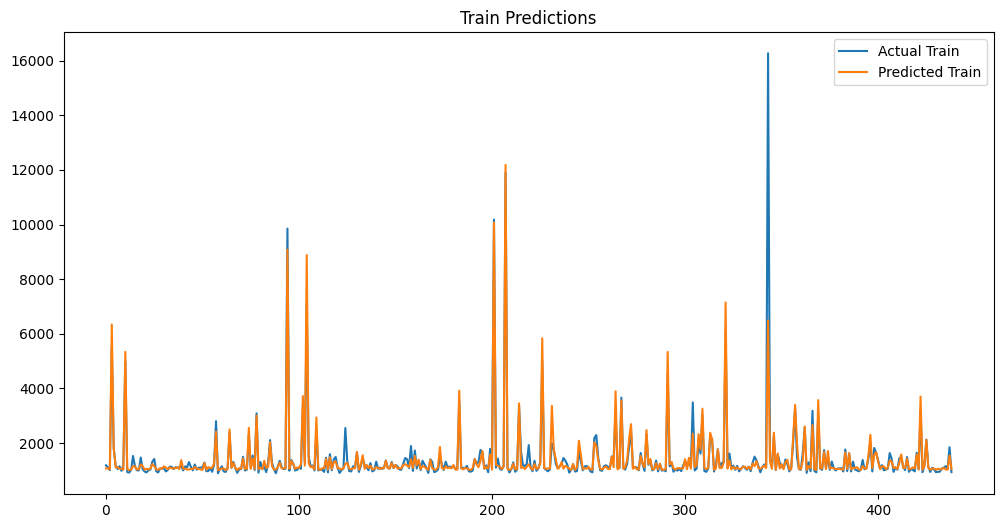

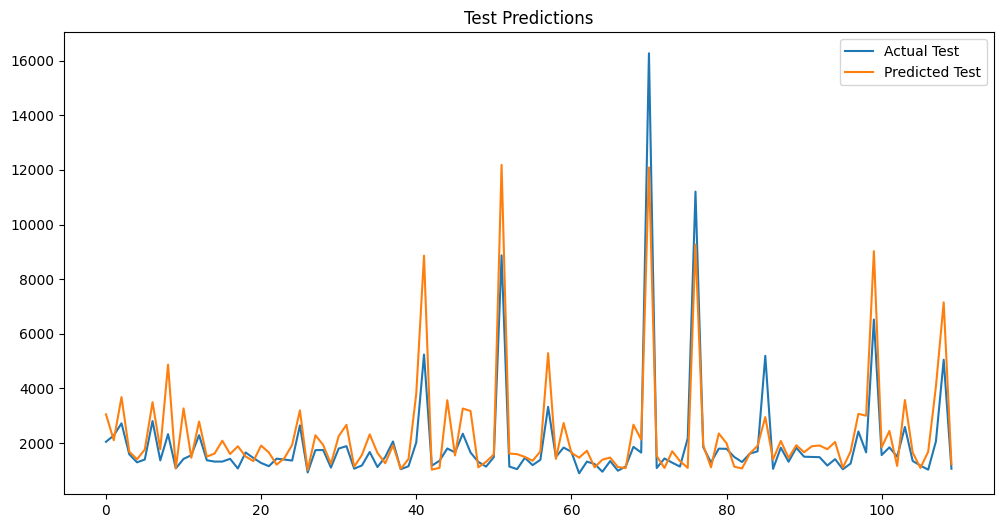

In [36]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    test_predictions = model(X_test).cpu().numpy()

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train_original = scaler.inverse_transform(y_train.cpu().numpy())
test_predictions = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.cpu().numpy())

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_train_original, label='Actual Train')
plt.plot(train_predictions, label='Predicted Train')
plt.legend()
plt.title('Train Predictions')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_original, label='Actual Test')
plt.plot(test_predictions, label='Predicted Test')
plt.legend()
plt.title('Test Predictions')
plt.show()

In [37]:
from torchinfo import summary

In [38]:
summary(model,input_size=(1,32,1))

Layer (type:depth-idx)                   Output Shape              Param #
gru_model                                [1, 1]                    --
├─GRU: 1-1                               [1, 32, 32]               9,696
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 64]                   2,112
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 1]                    65
Total params: 11,873
Trainable params: 11,873
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.31
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.06

In [39]:
from torchmetrics.regression import MeanAbsoluteError, R2Score, MeanSquaredError, MeanSquaredLogError

model.eval()
with torch.no_grad():
    y_preds = model(X_test.to(device))

# Ensure non-negative for MSLE
y_preds = torch.clamp(y_preds, min=0)
y_test = torch.clamp(y_test, min=0)

# Metrics
mae = MeanAbsoluteError().to(device)
r2 = R2Score().to(device)
mse = MeanSquaredError().to(device)
msle = MeanSquaredLogError().to(device)

# Compute
mae_val = mae(y_preds, y_test.to(device))
r2_val = r2(y_preds, y_test.to(device))
mse_val = mse(y_preds, y_test.to(device))
msle_val = msle(y_preds, y_test.to(device))

# Print
print(f"The MAE is  {mae_val.item():.4f}")
print(f"The R2-score is {r2_val.item():.4f}")
print(f"The MSE is {mse_val.item():.4f}")
print(f"The MSLE is {msle_val.item():.4f}")

The MAE is  0.0402
The R2-score is 0.7491
The MSE is 0.0041
The MSLE is 0.0025


In [40]:
import pandas as pd

# Create a dictionary with metric values
metrics = {
    "Metric": ["MAE", "R2 Score", "MSE", "MSLE"],
    "Value": [
        mae_val.item(),
        r2_val.item(),
        mse_val.item(),
        msle_val.item()
    ]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Save to Excel
df_metrics.to_excel("gru_metrics.xlsx", index=False, engine='openpyxl')


# Making Bi GRU Model

In [41]:
import torch
import torch.nn as nn
from torch.nn import GRU
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

In [ ]:
rows=train.iloc[56000,:].values


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
X=rows[0:549]
y=rows[1:550]

In [ ]:
#Lets split the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train.reshape(-1,1))
y_train=scaler.fit_transform(y_train.reshape(-1,1))
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [46]:
class biGRU(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(biGRU,self).__init__()
        self.gru=nn.GRU(input_size=input_shape,hidden_size=hidden_shape,num_layers=2,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_shape, 64),   # 2 * hidden_shape because the LSTM is bidirectional
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self, x):
        output, _ = self.gru(x)
        out = self.fc(output[:, -1, :])  # take only last time step
        return out  # shape: [batch, output_size]

In [47]:
bigru_model=biGRU(1,32,1).to(device)

In [49]:
loss_fn=nn.MSELoss()
optimizer = optim.Adam(bigru_model.parameters(), lr=0.001)

In [51]:
epochs = 500
bi_gru_train_loss=[]
for epoch in range(epochs):
    bigru_model.train()
    optimizer.zero_grad()
    outputs = bigru_model(X_train.to(device))
    loss = loss_fn(outputs, y_train.to(device))
    bi_gru_train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [10/500], Loss: 0.007702
Epoch [20/500], Loss: 0.006800
Epoch [30/500], Loss: 0.006604
Epoch [40/500], Loss: 0.006221
Epoch [50/500], Loss: 0.006194
Epoch [60/500], Loss: 0.005597
Epoch [70/500], Loss: 0.005118
Epoch [80/500], Loss: 0.004202
Epoch [90/500], Loss: 0.003217
Epoch [100/500], Loss: 0.001914
Epoch [110/500], Loss: 0.001926
Epoch [120/500], Loss: 0.001699
Epoch [130/500], Loss: 0.001593
Epoch [140/500], Loss: 0.001605
Epoch [150/500], Loss: 0.001467
Epoch [160/500], Loss: 0.001324
Epoch [170/500], Loss: 0.001641
Epoch [180/500], Loss: 0.001329
Epoch [190/500], Loss: 0.001449
Epoch [200/500], Loss: 0.001547
Epoch [210/500], Loss: 0.001751
Epoch [220/500], Loss: 0.001594
Epoch [230/500], Loss: 0.001185
Epoch [240/500], Loss: 0.001405
Epoch [250/500], Loss: 0.001403
Epoch [260/500], Loss: 0.001187
Epoch [270/500], Loss: 0.001456
Epoch [280/500], Loss: 0.001254
Epoch [290/500], Loss: 0.001080
Epoch [300/500], Loss: 0.001048
Epoch [310/500], Loss: 0.001264
Epoch [320/500], 

In [53]:
X_test=scaler.fit_transform(X_test.cpu().reshape(-1,1))
y_test=scaler.fit_transform(y_test.cpu().reshape(-1,1))
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

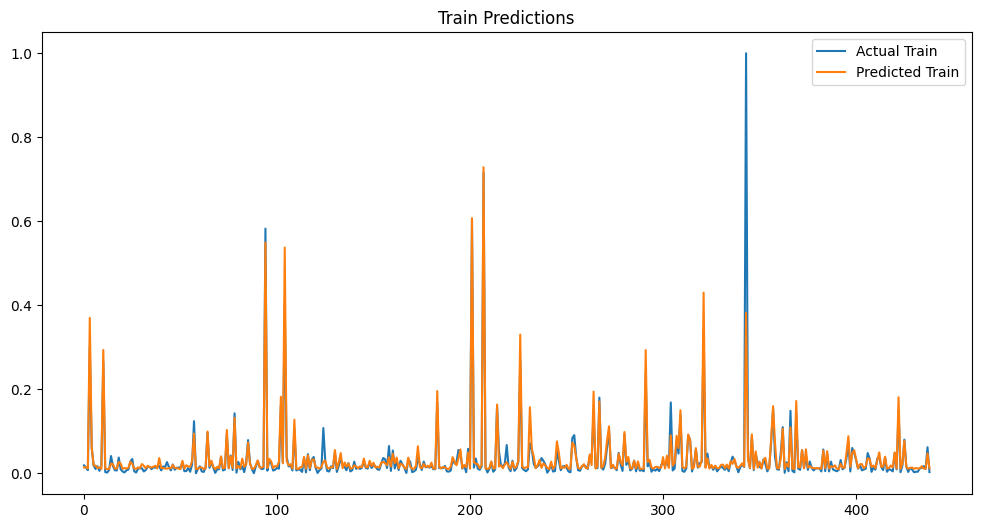

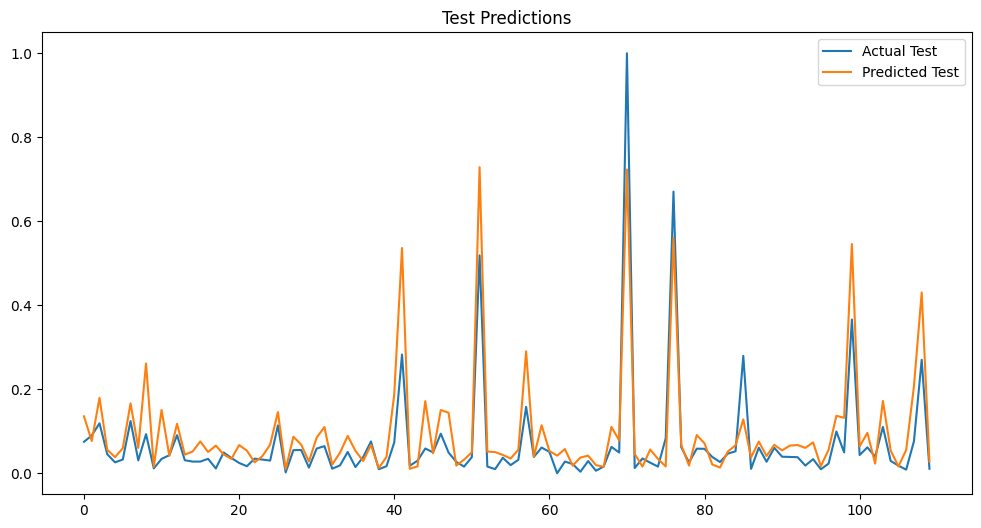

In [55]:
import matplotlib.pyplot as plt
bigru_model.eval()
with torch.inference_mode():
    train_predictions = bigru_model(X_train.to(device)).cpu().numpy()
    test_predictions = bigru_model(X_test.to(device)).cpu().numpy()

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train_original = scaler.inverse_transform(y_train.cpu().numpy())
test_predictions = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.cpu().numpy())

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_train_original, label='Actual Train')
plt.plot(train_predictions, label='Predicted Train')
plt.legend()
plt.title('Train Predictions')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_original, label='Actual Test')
plt.plot(test_predictions, label='Predicted Test')
plt.legend()
plt.title('Test Predictions')
plt.show()

In [57]:
from torchmetrics.regression import MeanAbsoluteError, R2Score, MeanSquaredError, MeanSquaredLogError

bigru_model.eval()
with torch.no_grad():
    y_preds = bigru_model(X_test.to(device))

# Ensure non-negative for MSLE
y_preds = torch.clamp(y_preds, min=0)
y_test = torch.clamp(y_test, min=0)

# Metrics
mae = MeanAbsoluteError().to(device)
r2 = R2Score().to(device)
mse = MeanSquaredError().to(device)
msle = MeanSquaredLogError().to(device)

# Compute
mae_val = mae(y_preds, y_test.to(device))
r2_val = r2(y_preds, y_test.to(device))
mse_val = mse(y_preds, y_test.to(device))
msle_val = msle(y_preds, y_test.to(device))

# Print
print(f"The MAE is  {mae_val.item():.4f}")
print(f"The R2-score is {r2_val.item():.4f}")
print(f"The MSE is {mse_val.item():.4f}")
print(f"The MSLE is {msle_val.item():.4f}")


The MAE is  0.0410
The R2-score is 0.7390
The MSE is 0.0043
The MSLE is 0.0025


In [58]:
import pandas as pd

# Create a dictionary with metric values
metrics = {
    "Metric": ["MAE", "R2 Score", "MSE", "MSLE"],
    "Value": [
        mae_val.item(),
        r2_val.item(),
        mse_val.item(),
        msle_val.item()
    ]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Save to Excel
df_metrics.to_excel("bilstm_metrics.xlsx", index=False, engine='openpyxl')


# Making BI-RNN

In [13]:
class birnn(nn.Module):
    def __init__(self,input_shape,hidden_shape,output_shape):
        super(birnn,self).__init__()
        self.rnn=nn.RNN(input_size=input_shape,hidden_size=hidden_shape,num_layers=2,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_shape, 64),   # 2 * hidden_shape because the LSTM is bidirectional
            nn.ReLU(),                         # ReLU activation
            nn.Dropout(0.2),                   # Dropout layer for regularization
            nn.Linear(64, output_shape)        # Final output layer
        )

    def forward(self, x):
        output, _ = self.rnn(x)
        out = self.fc(output[:, -1, :])  # take only last time step
        return out  # shape: [batch, output_size]

In [14]:
birnn=birnn(1,32,1).to(device)

In [19]:
loss_fn=nn.MSELoss()
optimizer = optim.Adam(birnn.parameters(), lr=0.001)

In [20]:
epochs = 500
bi_rnn_train_loss=[]
for epoch in range(epochs):
    birnn.train()
    optimizer.zero_grad()
    outputs = birnn(X_train.to(device))
    loss = loss_fn(outputs, y_train.to(device))
    bi_rnn_train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [10/500], Loss: 0.008087
Epoch [20/500], Loss: 0.005858
Epoch [30/500], Loss: 0.004882
Epoch [40/500], Loss: 0.004244
Epoch [50/500], Loss: 0.003720
Epoch [60/500], Loss: 0.003450
Epoch [70/500], Loss: 0.002705
Epoch [80/500], Loss: 0.002338
Epoch [90/500], Loss: 0.001964
Epoch [100/500], Loss: 0.001745
Epoch [110/500], Loss: 0.001566
Epoch [120/500], Loss: 0.001582
Epoch [130/500], Loss: 0.001817
Epoch [140/500], Loss: 0.001595
Epoch [150/500], Loss: 0.001602
Epoch [160/500], Loss: 0.001484
Epoch [170/500], Loss: 0.001672
Epoch [180/500], Loss: 0.001307
Epoch [190/500], Loss: 0.001292
Epoch [200/500], Loss: 0.001137
Epoch [210/500], Loss: 0.001474
Epoch [220/500], Loss: 0.001454
Epoch [230/500], Loss: 0.001639
Epoch [240/500], Loss: 0.001390
Epoch [250/500], Loss: 0.001414
Epoch [260/500], Loss: 0.001246
Epoch [270/500], Loss: 0.001364
Epoch [280/500], Loss: 0.001466
Epoch [290/500], Loss: 0.001359
Epoch [300/500], Loss: 0.001302
Epoch [310/500], Loss: 0.001449
Epoch [320/500], 

In [22]:
X_test=scaler.fit_transform(X_test.reshape(-1,1))
y_test=scaler.fit_transform(y_test.reshape(-1,1))
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

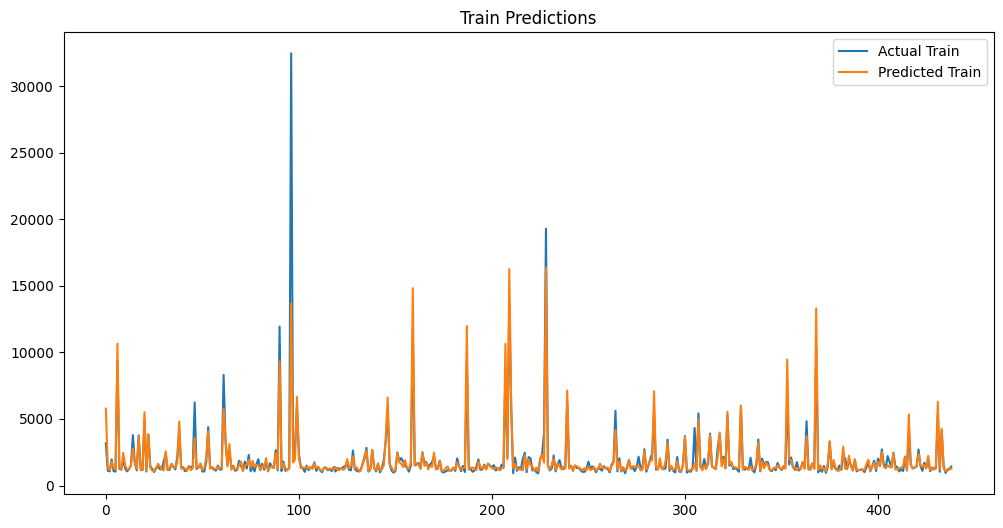

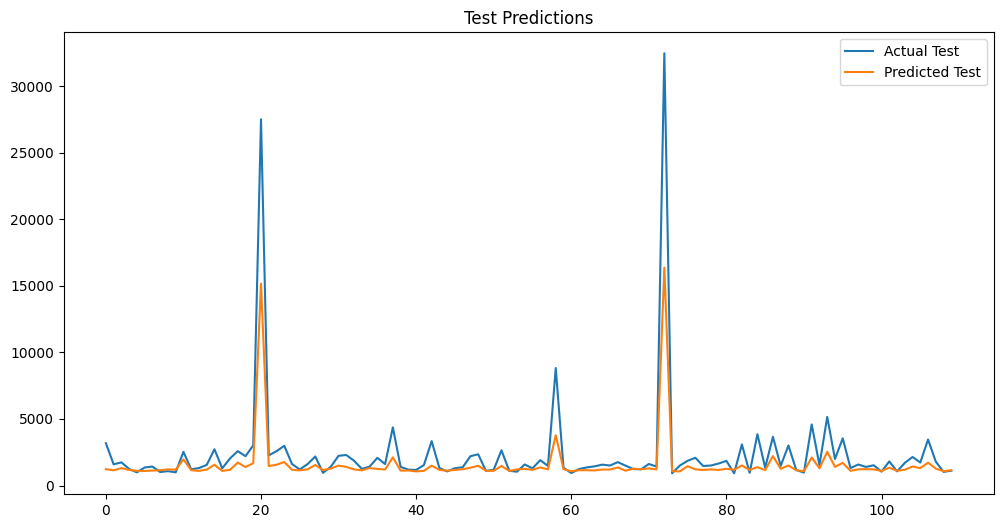

In [25]:
import matplotlib.pyplot as plt
birnn.eval()
with torch.inference_mode():
    train_predictions = birnn(X_train.to(device)).cpu().numpy()
    test_predictions = birnn(X_test.to(device)).cpu().numpy()

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train_original = scaler.inverse_transform(y_train.cpu().numpy())
test_predictions = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.cpu().numpy())

# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_train_original, label='Actual Train')
plt.plot(train_predictions, label='Predicted Train')
plt.legend()
plt.title('Train Predictions')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_original, label='Actual Test')
plt.plot(test_predictions, label='Predicted Test')
plt.legend()
plt.title('Test Predictions')
plt.show()

In [28]:
from torchmetrics.regression import MeanAbsoluteError, R2Score, MeanSquaredError, MeanSquaredLogError

birnn.eval()
with torch.no_grad():
    y_preds = birnn(X_test.to(device))

# Ensure non-negative for MSLE
y_preds = torch.clamp(y_preds, min=0)
y_test = torch.clamp(y_test, min=0)

# Metrics
mae = MeanAbsoluteError().to(device)
r2 = R2Score().to(device)
mse = MeanSquaredError().to(device)
msle = MeanSquaredLogError().to(device)

# Compute
mae_val = mae(y_preds, y_test.to(device))
r2_val = r2(y_preds, y_test.to(device))
mse_val = mse(y_preds, y_test.to(device))
msle_val = msle(y_preds, y_test.to(device))

# Print
print(f"The MAE is  {mae_val.item():.4f}")
print(f"The R2-score is {r2_val.item():.4f}")
print(f"The MSE is {mse_val.item():.4f}")
print(f"The MSLE is {msle_val.item():.4f}")


The MAE is  0.0260
The R2-score is 0.7020
The MSE is 0.0046
The MSLE is 0.0020


In [30]:
import pandas as pd

# Create a dictionary with metric values
metrics = {
    "Metric": ["MAE", "R2 Score", "MSE", "MSLE"],
    "Value": [
        mae_val.item(),
        r2_val.item(),
        mse_val.item(),
        msle_val.item()
    ]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics)

# Save to Excel
df_metrics.to_excel("birnn_metrcis.xlsx", index=False, engine='openpyxl')